In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from joblib import Parallel, delayed
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
import itertools
import joblib

In [2]:
#read csv
df = pd.read_csv("RFLFSODataFull.csv")
df.head()
df.describe()


,FSO_Att,RFL_Att,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,...,TemperatureMax,TemperatureMin,Time,Visibility,VisibilityMax,VisibilityMin,WindDirection,WindSpeed,WindSpeedMax,WindSpeedMin
count,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,9.137900e+04,91379.000000,91379.000000,91379.000000,...,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000
mean,6.769458,11.619098,9.553919,10.032760,9.076251,3297.930328,7.850005e+10,27.065979,28.417120,25.717089,...,13.166020,11.904558,11.373193,32986.417484,34636.684647,31331.618978,89.043304,0.739065,1.851020,0.702242
std,3.903843,3.438873,5.858577,6.162798,5.575927,1224.305893,5.000027e+09,72.134023,75.761896,68.595239,...,9.589755,8.694028,6.942229,24713.874445,25978.845228,23497.873065,26.415610,0.871314,1.762698,0.828796
min,0.788363,0.027142,1.141556,1.238270,1.049744,2012.000148,7.350000e+10,0.000000,0.000000,0.000000,...,-6.693373,-7.270075,0.000000,10.151990,11.029667,9.484346,0.000000,0.000000,0.000000,0.000000
25%,3.473063,10.829331,4.958993,5.205861,4.709511,2019.431812,7.350000e+10,0.000000,0.000000,0.000000,...,4.905387,4.438425,5.000000,11158.598400,11721.447542,10588.793237,82.976727,0.076749,0.512667,0.072912
50%,6.336167,11.856560,6.870737,7.205499,6.524046,2959.863686,8.350000e+10,0.000000,0.000000,0.000000,...,10.803943,9.774467,11.000000,26378.636210,27686.214032,25047.188462,90.867362,0.437995,1.323101,0.416274
75%,8.664984,12.847944,14.049470,14.782679,13.379256,4820.890157,8.350000e+10,16.947618,17.775980,16.038090,...,22.470382,20.322434,17.000000,53493.821285,56092.212376,50797.690402,98.482652,1.088621,2.681788,1.036574
max,32.455222,46.893150,24.790883,26.407305,24.268431,4827.999971,8.350000e+10,1621.001906,1753.747866,1500.666382,...,40.771383,36.724191,23.000000,75004.999150,82503.130084,74999.343414,360.000000,7.799086,16.421115,7.252319


In [3]:
#preprocessing
X=df.drop(columns=['FSO_Att','RFL_Att'])
y_FSO=df['FSO_Att']
y_RFL=df['RFL_Att']
X_train,X_test,y_FSO_train,y_FSO_test=train_test_split(
    X,y_FSO,train_size=0.8,test_size=0.2,random_state=1874845,stratify=df['SYNOPCode']
)
X_train,X_test,y_RFL_train,y_RFL_test=train_test_split(
    X,y_RFL,train_size=0.8,test_size=0.2,random_state=1874845,stratify=df['SYNOPCode']
)
y_FSO_test.head()


68601    13.077835
68115     4.450609
28357     2.890493
17893     5.953451
60284     9.631533
Name: FSO_Att, dtype: float64

In [4]:
#stratified sampling trainset
X_synop_0 = X_train[X_train['SYNOPCode'] == 0]
y_synop_0_FSO = y_FSO_train[X_synop_0.index]
y_synop_0_RFL = y_RFL_train[X_synop_0.index]
# group trainset by Distance, time and Frequency
# create an empty list to save sample
sampled_X = []
sampled_y_FSO = []
sampled_y_RFL = []
#stratified sampling X
sampled_X=X_synop_0.groupby(['Distance','Frequency','Time'], group_keys=False).apply(
    lambda group:group.sample(n=min(5, len(group)), random_state=42)
)
#make Y correspond to X
sampled_y_FSO=y_synop_0_FSO.loc[sampled_X.index]
sampled_y_RFL=y_synop_0_RFL.loc[sampled_X.index]
#delete synop_0 data in the trainset
X_no_synop_0 = X_train[X_train['SYNOPCode'] != 0].reset_index(drop=True)
y_FSO_no_synop_0 = y_FSO_train[X_train['SYNOPCode'] != 0].reset_index(drop=True)
y_RFL_no_synop_0 = y_RFL_train[X_train['SYNOPCode'] != 0].reset_index(drop=True)
#merge data with deleted trainest and sampled synop_0 trainset data
X_combined = pd.concat([X_no_synop_0, sampled_X], ignore_index=True)
y_FSO_combined = pd.concat([y_FSO_no_synop_0, sampled_y_FSO], ignore_index=True)
y_RFL_combined = pd.concat([y_RFL_no_synop_0, sampled_y_RFL], ignore_index=True)
#redistribute data
combined = pd.concat([X_combined, y_FSO_combined, y_RFL_combined], axis=1)
shuffled_combined = combined.sample(frac=1, random_state=42).reset_index(drop=True)
X_train = shuffled_combined.iloc[:, :-2]
y_FSO_train = shuffled_combined.iloc[:, -2]
y_RFL_train = shuffled_combined.iloc[:, -1]

In [5]:
#define function to create interaction
def create_interaction_terms(df, interaction_vars):
    df_interactions=pd.DataFrame()
    for var in interaction_vars:
        if '*' in var:
            var1, var2 = var.split('*')
            df_interactions[var] = df[var1] * df[var2]
        else:
            df_interactions[var] = df[var]
    return df_interactions
variables = {
    'Overall_FSO_Att': ['Time', 'TemperatureDifference', 'TemperatureMin', 'AbsoluteHumidity', 'ParticulateMin*Distance', 'Temperature*Distance', 'Distance', 'Visibility*Distance'],
    'Overall_RFL_Att': ['Frequency', 'Visibility', 'RelativeHumidity', 'Distance', 'Distance*RainIntensity', 'AbsoluteHumidity'],
}

In [6]:
#Prepare RFL trainset for FSO-RFL hybrid model
print(X_train.shape)
overall_fso = RandomForestRegressor(n_estimators=200, random_state=1874845)
X_train_fso=create_interaction_terms(X_train,variables['Overall_FSO_Att'])
overall_fso.fit(X_train_fso,y_FSO_train)
joblib.dump(overall_fso, "Overall_FSO_Att.joblib")

#Fitting FSO model
FSO_pred=overall_fso.predict(X_train_fso)
print(FSO_pred.shape)
#add FSO_pred into RFL trainset
X_train_RFL=X_train.copy()
X_train_RFL['FSO_pred']=FSO_pred
print(X_train_RFL)




(73103, 25)
(73103,)
       AbsoluteHumidity  AbsoluteHumidityMax  AbsoluteHumidityMin  \
0             19.409466            19.821508            19.071026   
1              4.735022             5.149081             4.310300   
2              3.278151             3.569293             3.164491   
3              6.117897             6.422243             5.759406   
4              6.007126             6.422619             5.765845   
...                 ...                  ...                  ...   
73098         18.785538            19.340281            18.379211   
73099          6.020335             6.585386             5.826840   
73100         10.688433            10.839295             9.810153   
73101          9.902738             9.936302             8.954657   
73102         16.553406            17.358941            15.898162   

          Distance    Frequency  Particulate  ParticulateMax  ParticulateMin  \
0      2960.774271  83500000000     0.000000        0.000000        0.

In [7]:
#Prepare FSO trainset for RFL-FSO hybrid model
overall_rfl = RandomForestRegressor(n_estimators=200, random_state=1874845)
X_train_rfl=create_interaction_terms(X_train,variables['Overall_RFL_Att'])
overall_rfl.fit(X_train_rfl,y_RFL_train)
joblib.dump(overall_rfl, "Overall_RFL_Att.joblib")

#Fitting RFL model
RFL_pred=overall_rfl.predict(X_train_rfl)
print(RFL_pred.shape)
#add RFL_pred into FSO trainset
X_train_FSO=X_train.copy()
X_train_FSO['RFL_pred']=RFL_pred
print(X_train_FSO)

(73103,)
       AbsoluteHumidity  AbsoluteHumidityMax  AbsoluteHumidityMin  \
0             19.409466            19.821508            19.071026   
1              4.735022             5.149081             4.310300   
2              3.278151             3.569293             3.164491   
3              6.117897             6.422243             5.759406   
4              6.007126             6.422619             5.765845   
...                 ...                  ...                  ...   
73098         18.785538            19.340281            18.379211   
73099          6.020335             6.585386             5.826840   
73100         10.688433            10.839295             9.810153   
73101          9.902738             9.936302             8.954657   
73102         16.553406            17.358941            15.898162   

          Distance    Frequency  Particulate  ParticulateMax  ParticulateMin  \
0      2960.774271  83500000000     0.000000        0.000000        0.000000   
1 

In [8]:
# #define feature selection function
def fs(trainX, trainy, testX, testy):
    # Initialize S as the set of all predictor variables
    features = trainX.columns.tolist()
    #  Initialize an empty table R
    result_table = pd.DataFrame(columns=['feature', 'RMSE', 'R2_score'])
    print('----start training----')
    while features:
        # Train a random forest with the current set of features
        rf = RandomForestRegressor(n_estimators=100, random_state=1874845, oob_score=True)
        rf.fit(trainX[features], trainy)
        
        # Calculate RMSE and R2 for the current random forest
        y_pred = rf.predict(testX[features])
        rmse = np.sqrt(mean_squared_error(testy, y_pred))
        r2 = r2_score(testy, y_pred)
        
        # Rank importance and find the least important feature
        importance = rf.feature_importances_
        importance_df = pd.DataFrame({'feature': features, 'importance': importance})
        importance_df = importance_df.sort_values(by='importance', ascending=True)
        least_important_feature = importance_df.iloc[0]['feature']
        
        # Remove the least important feature from S and log the results
        features.remove(least_important_feature)
        Feature_info = pd.DataFrame([{
            'feature': least_important_feature,
            'RMSE': rmse,
            'R2_score': r2
        }])

        # Concatenate the new row to the result table
        result_table = pd.concat([result_table, Feature_info], ignore_index=True)
        
        # Display progress
        tqdm.write(f"Removed: {least_important_feature}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

    return result_table

In [25]:
#define plot function
def plot_results(results,Type):
    # Extract data from result_RFL
    features = results['feature']
    rmse_values = results['RMSE']
    r2_values = results['R2_score']

    # Create the figure and subplots
    fig,ax1 = plt.subplots( figsize=(10, 6), sharex=False)

    # Plotting result
    ax1.plot(features, rmse_values, color='blue', marker='o', label='RMSE')
    ax1.set_xlabel('Features',fontsize=14)
    ax1.set_ylabel('RMSE', color='blue',fontsize=14)
    ax1.tick_params(axis='x', rotation=90)
    ax1.grid(True)

    # Second y-axis for R² in result
    ax1_twin = ax1.twinx()
    ax1_twin.plot(features, r2_values, color='red', marker='x', label='R²')
    ax1_twin.set_ylabel('R²', color='red',fontsize=14)
    ax1_twin.tick_params(axis='y', colors='red')
    if Type=='RFL':
        ax1.set_title('RFL model Feature Importance Analysis',fontsize=14)
    else:
        ax1.set_title('FSO model Feature Importance Analysis',fontsize=14)
    plt.tight_layout()

    # Show the combined plot
    plt.show()


In [10]:
def process(Type):
    if Type=='RFL':
        fso_test_pred=overall_fso.predict(create_interaction_terms(X_test,variables['Overall_FSO_Att']))
        X_RFL_test=X_test.copy()   
        X_RFL_test['FSO_pred']=fso_test_pred
        result_RFL = fs(X_train_RFL, y_RFL_train, X_RFL_test, y_RFL_test)
        return result_RFL
    else:
        rfl_test_pred=overall_rfl.predict(create_interaction_terms(X_test,variables['Overall_RFL_Att']))
        X_FSO_test=X_test.copy()   
        X_FSO_test['RFL_pred']=rfl_test_pred
        result_FSO = fs(X_train_FSO, y_FSO_train, X_FSO_test, y_FSO_test)
        return result_FSO

In [11]:
g_result_RFL=process('RFL')

----start training----
Removed: WindDirection, RMSE: 0.4598, R2: 0.9828
Removed: WindSpeed, RMSE: 0.4582, R2: 0.9829
Removed: WindSpeedMin, RMSE: 0.4570, R2: 0.9830
Removed: WindSpeedMax, RMSE: 0.4582, R2: 0.9829
Removed: Particulate, RMSE: 0.4501, R2: 0.9835
Removed: AbsoluteHumidityMin, RMSE: 0.4506, R2: 0.9835
Removed: VisibilityMax, RMSE: 0.4454, R2: 0.9839
Removed: TemperatureDifference, RMSE: 0.4457, R2: 0.9838
Removed: AbsoluteHumidityMax, RMSE: 0.4794, R2: 0.9813
Removed: ParticulateMin, RMSE: 0.4740, R2: 0.9817
Removed: VisibilityMin, RMSE: 0.4722, R2: 0.9819
Removed: Time, RMSE: 0.4734, R2: 0.9818
Removed: Frequency, RMSE: 0.5173, R2: 0.9782
Removed: RelativeHumidity, RMSE: 0.6792, R2: 0.9625
Removed: Visibility, RMSE: 0.6901, R2: 0.9613
Removed: TemperatureMin, RMSE: 0.7259, R2: 0.9572
Removed: ParticulateMax, RMSE: 0.7202, R2: 0.9578
Removed: TemperatureMax, RMSE: 0.7410, R2: 0.9554
Removed: SYNOPCode, RMSE: 0.7425, R2: 0.9552
Removed: RainIntensityMin, RMSE: 0.7434, R2: 0.

In [12]:
g_result_FSO=process('FSO')

----start training----
Removed: Frequency, RMSE: 0.8798, R2: 0.9508
Removed: RainIntensity, RMSE: 0.8798, R2: 0.9508
Removed: RainIntensityMin, RMSE: 0.8785, R2: 0.9509
Removed: SYNOPCode, RMSE: 0.8792, R2: 0.9508
Removed: WindDirection, RMSE: 0.8806, R2: 0.9507
Removed: RainIntensityMax, RMSE: 0.8716, R2: 0.9517
Removed: WindSpeed, RMSE: 0.8730, R2: 0.9515
Removed: AbsoluteHumidityMin, RMSE: 0.8712, R2: 0.9517
Removed: AbsoluteHumidityMax, RMSE: 0.8672, R2: 0.9522
Removed: WindSpeedMin, RMSE: 0.8600, R2: 0.9530
Removed: WindSpeedMax, RMSE: 0.8716, R2: 0.9517
Removed: TemperatureMax, RMSE: 0.8888, R2: 0.9498
Removed: TemperatureDifference, RMSE: 0.8846, R2: 0.9502
Removed: Time, RMSE: 0.9554, R2: 0.9419
Removed: VisibilityMax, RMSE: 1.1304, R2: 0.9187
Removed: ParticulateMax, RMSE: 1.1301, R2: 0.9188
Removed: RelativeHumidity, RMSE: 1.1280, R2: 0.9191
Removed: AbsoluteHumidity, RMSE: 1.1395, R2: 0.9174
Removed: TemperatureMin, RMSE: 1.2867, R2: 0.8947
Removed: Particulate, RMSE: 1.2787

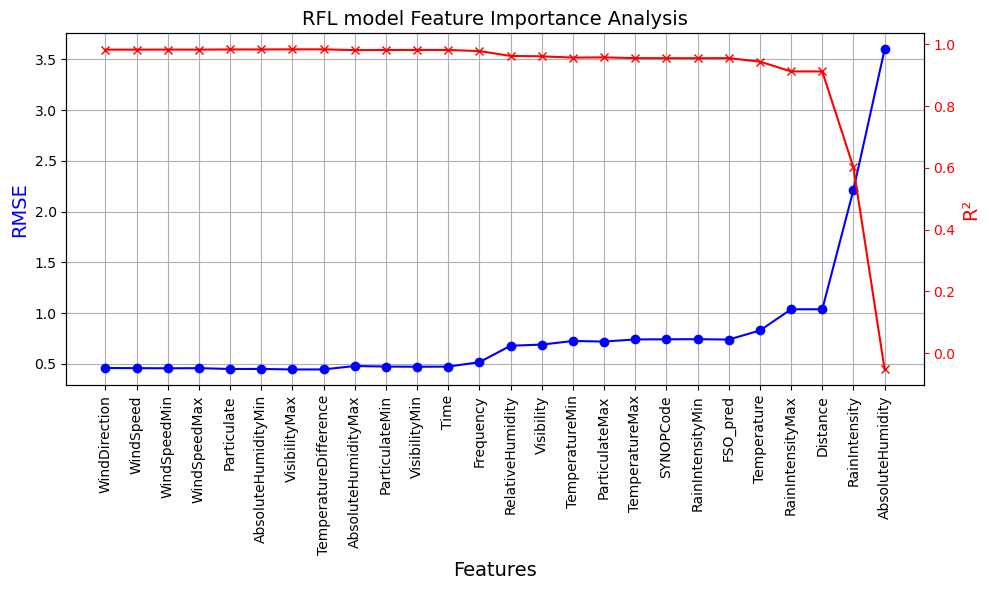

In [26]:
plot_results(g_result_RFL,'RFL')

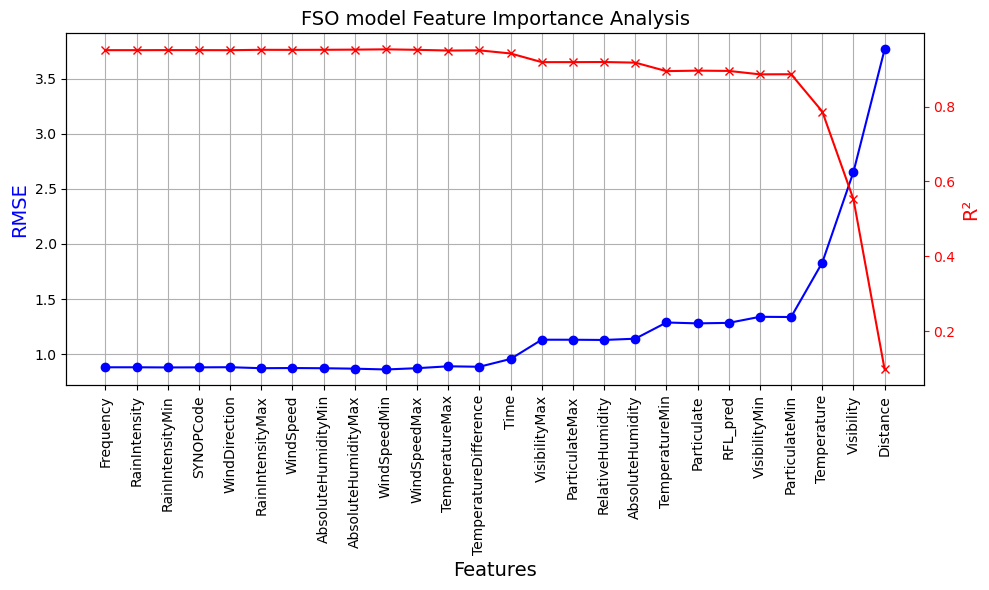

In [27]:
plot_results(g_result_FSO,'FSO')